<font size="3">
<center><b>Анализ бизнес-показателей приложения Procrastinate Pro+</b></center>
<br> Описание проекта.
<br> В данном проекте нам предстоит проанализировать работу развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.
    <br>В нашем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
   
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

    <br> Нам предстоит изучить:
    
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.
</font>

### Загрузим данные и подготовим их к анализу

In [1]:
#импортируем библиотеки, которые пригодятся нам в дальнейшей работе
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import math
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
#Загружаем данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.
visit = pd.read_csv('/datasets/visits_info_short.csv')
order = pd.read_csv('/datasets/orders_info_short.csv')
cost = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# посмотрим первые 5 строк таблицы визиты
visit.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visit.info()# оценим тип представленных данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Столбцы с датой необходимо привести к типу datetime, а так же переименовать названия столбцов: привести к змеиному/нижнему регистру.

In [5]:
# меняем названия столбцов
#visit.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visit.columns = visit.columns.str.lower().str.replace(' ', '_')

In [6]:
#приводим столбцы session_start, session_end к типу даты
visit['session_start'] = pd.to_datetime(visit['session_start'])
visit['session_end'] = pd.to_datetime(visit['session_end'])
#visit.info()

In [7]:
visit.duplicated().sum()#проверим на наличие явных дубликатов

0

In [8]:
visit.isna().sum()# посмотрим количество пропусков

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [9]:
visit['region'].unique()#смотрим уникальнве значения в столбце регион

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [10]:
visit['device'].unique()#смотрим уникальнве значения в столбце девайс

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [11]:
visit['channel'].unique()#смотрим уникальнве значения в столбце канал привлечения

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

<font size="3">
Таблица visit имеет 309901 строк и содержит следующую информацию:
    
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.
<br> В таблице хранятся данные о пользователях из 4 стран: США, Великобритания, Франция, Германия. Устройства, с которых регистрируются пользователи, тоже 4. Привлекаются пользователи из 11 различных каналов.
<br> *Проанализируем аналогичным образом следующие две таблицы:  order и cost.*
</font>

In [12]:
print(order.head())#смотрим первые 5 строк таблицы
print(order.info())#смотрим общую информацию

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


In [13]:
order.columns = ['user_id', 'event_dt', 'revenue']# приводим названия столбцов к нижнему/змеиному регистру
order['event_dt'] = pd.to_datetime(order['event_dt'])# меняем тип даты
#order.info()

In [14]:
#оценим среднее, медиану, минимальные и максимальные показатели в суммах заказа
order['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [15]:
order['revenue'].value_counts()

4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
Name: revenue, dtype: int64

In [16]:
order.duplicated().sum()#проверим на наличие явных дубликатов

0

<font size="3">
Таблица order имеет 40212 строк и содержит следующую информацию:
    
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.
<br> В 96% случаев заказ совершается а сумму 4.99- это минимальная сумма заказа. Максимальный заказ был совершен на сумму 49.99
</font>

In [17]:
print(cost.head())#смотрим первые 5 строк таблицы
print(cost.info())#смотрим общую информацию

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


In [18]:
cost['dt'] = pd.to_datetime(cost['dt'])# меняем тип даты
cost.columns = cost.columns.str.lower()# приводим к нижнему регистру название столбцов
#cost.info()

In [19]:
cost['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

In [20]:
cost.duplicated().sum()#проверим на наличие явных дубликатов

0

<font size="3">
Таблица cost имеет 1800 строк и содержит следующую информацию:
    
- dt — дата проведения рекламной кампании,
- channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.
<br> Видим большой разброс по затратам на рекламные кампании. Седннее значение от медианы отличается на 46 долларов. Стандартное отклонение равно 107,7. Минимальная рекламная кампания обошлась в 0.8 долларов, а максимальная в 630. Болле 75% всех рекламных кампаний приходятся на суммму до 34 долларов.
</font>

### Задаём функции для расчёта и анализа LTV, ROI, удержания и конверсии.



In [21]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [22]:
# функция для расчёта удержания

# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [23]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [24]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [25]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [26]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [27]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [28]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

Получим профили пользователей, вызвав функцию get_profiles и передав ей в качестве аргумента таблицы visit, order, cost

In [29]:
profiles = get_profiles(visit, order, cost)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей

In [30]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()

In [31]:
print('Минимальная дата привлечения клиентов:',min_analysis_date)
print('Максимальная дата привлечения клиентов:',max_analysis_date)

Минимальная дата привлечения клиентов: 2019-05-01 00:00:00
Максимальная дата привлечения клиентов: 2019-10-27 00:00:00


**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.**

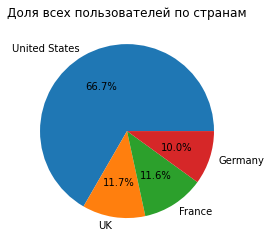

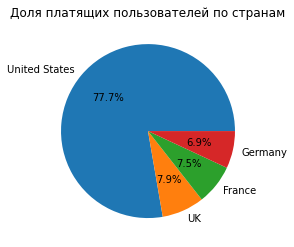

In [32]:
country_payment = profiles.groupby('region').agg({'user_id': 'count', 'payer': 'sum'})\
.sort_values(by='user_id', ascending=False)
#Построим круговую диаграмму, чтобы посмотреть долю всех пользователей по странам в %
fig1, ax1 = plt.subplots()
ax1.pie(country_payment['user_id'], labels=country_payment.index, autopct='%1.1f%%')
ax1.set_title('Доля всех пользователей по странам')
#Построим круговую диаграмму, чтобы посмотреть долю платящих пользователей по странам в %
fig2, ax2 = plt.subplots()
ax2.pie(country_payment['payer'], labels=country_payment.index, autopct='%1.1f%%')
ax2.set_title('Доля платящих пользователей по странам')
plt.show()

In [33]:
#посчитаем процент платящих пользователей по каждой стране
country_payment['percent_payment'] = country_payment['payer']/country_payment['user_id']*100
country_payment

,user_id,payer,percent_payment
region,,,
United States,100002,6902,6.901862
UK,17575,700,3.982930
France,17450,663,3.799427
Germany,14981,616,4.111875


**Вывод:** Из всех пользователей приложения, львиную долю составляют пользователи США- 66,7% . Из других стран: Франции, Германии, Великобританиии пользователей примерно одинаково- 10-12%. Ожидаемо, и платящих пользователей больше всего в США- 77,7% от всех платящих пользователей. 
<br>Если брать процент платящих пользователей от общего количество пользователей по каждой стране в отдельности, то тут картина безрадужная: платят пользователи только в 3,7-6,9% случаев. Охотнее всего платят в США-6.9%, хуже всего во Франции-3,7%

**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.**

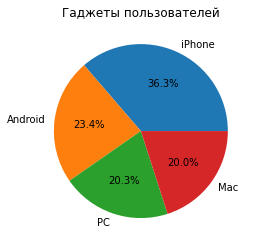

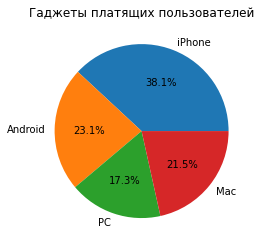

In [34]:
device_payment = profiles.groupby('device').agg({'user_id': 'count', 'payer': 'sum'})\
.sort_values(by='user_id', ascending=False)
#Построим круговую диаграмму, чтобы посмотреть долю устрйств пользователей в %
fig1, ax1 = plt.subplots()
ax1.pie(device_payment['user_id'], labels=device_payment.index, autopct='%1.1f%%')
ax1.set_title('Гаджеты пользователей')
#Построим круговую диаграмму, чтобы посмотреть долю устрйств платящих пользователей в %
fig2, ax2 = plt.subplots()
ax2.pie(device_payment['payer'], labels=device_payment.index, autopct='%1.1f%%')
ax2.set_title('Гаджеты платящих пользователей')
plt.show()

In [35]:
#посчитаем процент платящих пользователей по гаджету
device_payment['percent_payment'] = device_payment['payer']/device_payment['user_id']*100
device_payment

,user_id,payer,percent_payment
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


**Вывод:** Чаще всего пользователи используют приложение на Айфон- 36%. Доля приложений на МАС, Андроидах и РС примерно одинаковая- от 20 до 23,4%. Гаджеты платящих пользователей распределились прямопропорционально- первое место у Айфон- 38%, далее Андроид -23%, МАС и РС - 21% и 17%, соответстенно.  
Меняют статус из "неплатящих" на "вплатящих" неохотно все пользователи, независимо от устройства: всего 5-6%.

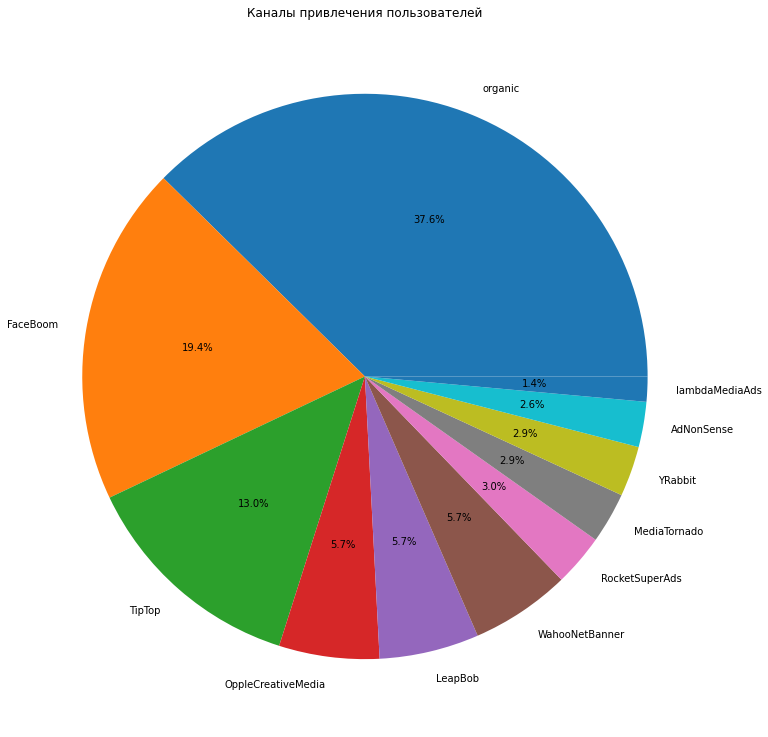

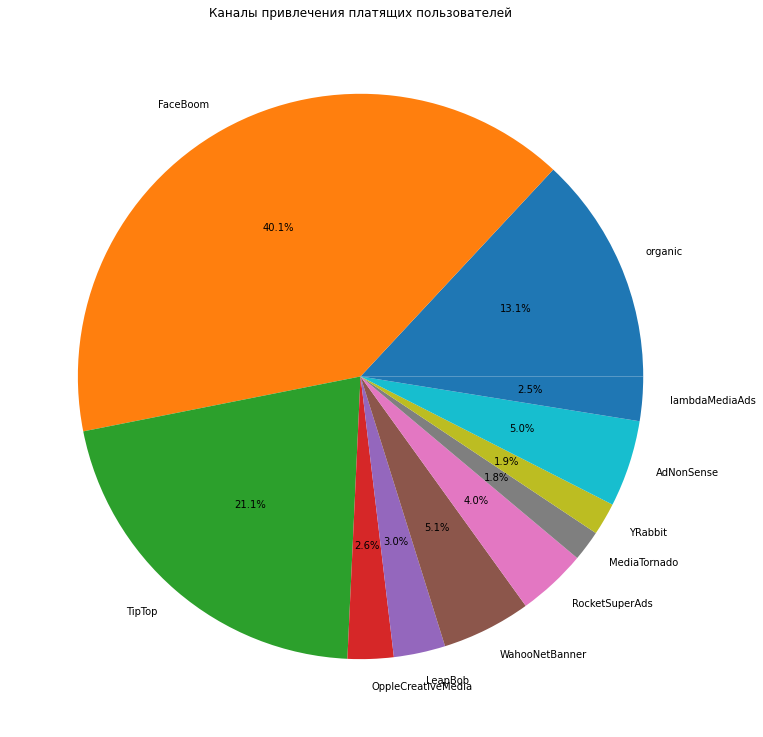

In [36]:
channel_payment = profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'})\
.sort_values(by='user_id', ascending=False)
#Построим круговую диаграмму, чтобы посмотреть каналы привлечения пользователей в %
fig1, ax1 = plt.subplots(figsize=(13,13))
ax1.pie(channel_payment['user_id'], labels=channel_payment.index, autopct='%1.1f%%')
ax1.set_title('Каналы привлечения пользователей')
#Построим круговую диаграмму, чтобы посмотреть каналы привлечения платящих пользователей в %
fig2, ax2 = plt.subplots(figsize=(13,13))
ax2.pie(channel_payment['payer'], labels=channel_payment.index, autopct='%1.1f%%')
ax2.set_title('Каналы привлечения платящих пользователей')
plt.show()

In [37]:
#посчитаем процент платящих пользователей по каналу привлечения
channel_payment['percent_payment'] = channel_payment['payer']/channel_payment['user_id']*100
channel_payment = channel_payment.sort_values(by='percent_payment', ascending=False)
channel_payment

,user_id,payer,percent_payment
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


**Вывод:** Из всех пользователей приложения, бОльшую часть составляют "Органические"- почти 37%. Также большая доля пользователей привлечены через каналы Фэйсбум и Типтоп- 19% и 13%. Оставшиеся 30% пользователей привлечены сумарно из 8  каналов привлечения, доля каждого из которых не превышает 5,7% от общего числа пользователей.  
Что касается пользователей, имеющих статус "платящих", то тут безусловное лидерство занимают пользователи, привлечённые из канала Типтоп. Их доля составляет 40% от общего числа платящих пользователей. Второе место среди "платящих" занимают пользователи, перешедшие их канала Типтоп- 21%. Доля "органики" - 13%. Оставшиеся 8 каналов сумарно составляют 26%, доля каждого из которыз не превышает 5%.  
Если смотреть процент перехода из "неплатящих" в "платящих" по каждому каналу, то тут картина заметно меняется: чаще всего готовы соверщать покупки пользователи из Фэйсбум, AdNonSense, lammbdaMediaAds, Типтоп, RocketSuper- процент совершенных покупок у них от 8 до 12%.

### Маркетинг



**Посчитаем общую сумму расходов на маркетинг и выясним, как траты распределены по рекламным источникам**

In [38]:
cost['costs'].sum()

105497.30000000002

Общая сумма завтрат на рекламу составила порядка 105497,3$

**Посмотрим, как траты на маркетинг распределены по источникам.**

In [39]:
profiles.groupby('channel').agg({'acquisition_cost': 'sum'})\
.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


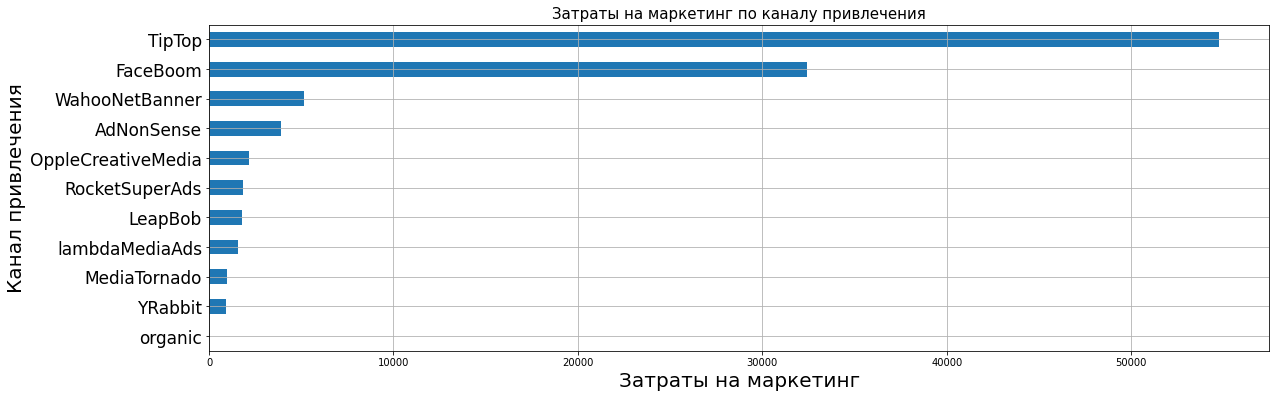

In [40]:
#Для наглядности построим диаграмму распределения затрат по источникам
params = {'ytick.labelsize': 17,
          'axes.titlesize': 15}
plt.rcParams.update(params)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
(
    profiles.groupby('channel').agg({'acquisition_cost': 'sum'})
    .sort_values(by='acquisition_cost')
    .plot(kind= 'barh', figsize=(19,6), legend = False,  grid=True)
)
plt.xlabel('Затраты на маркетинг', fontsize=20)
plt.ylabel('Канал привлечения', fontsize=20)
plt.title('Затраты на маркетинг по каналу привлечения');

**Вывод:**  Мы видим огромные расходы на рекламу в канале Тiptop: на них приходится практически половина всех расходов на рекламу. Пока не понятно- чем это обоснавоно, ведь совершают покупки пользователи этого канала в 10% из 100. Еще один канал с наибольшей суммой затрат на рекламу Faceboom. Затраты на привлечение пользователей с оставшихся каналов более-менее разумные и не превышают 6000$

**Посмотрим динамику изменения расходов во времени(по неделям и месяцам) по каждому источнику**

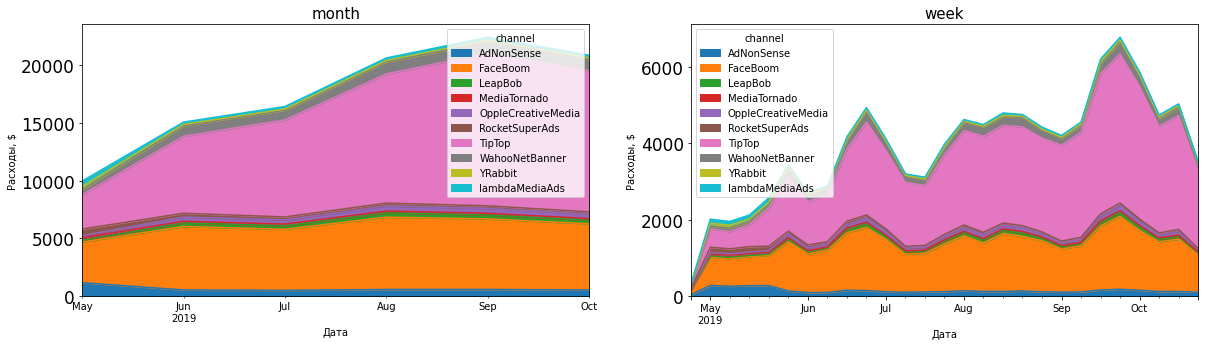

In [41]:
cost['month'] = cost['dt'].astype('datetime64[M]')# создаем cтолбец с датой в формате месяцев
cost['week'] = cost['dt'].astype('datetime64[W]')#создаем cтолбец с датой в формате месяцев
columns = ['month', 'week']
plt.subplots(figsize = (20, 5))
for i, col in enumerate(columns):
    cost.pivot_table(index = col, columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
  
plt.show() 

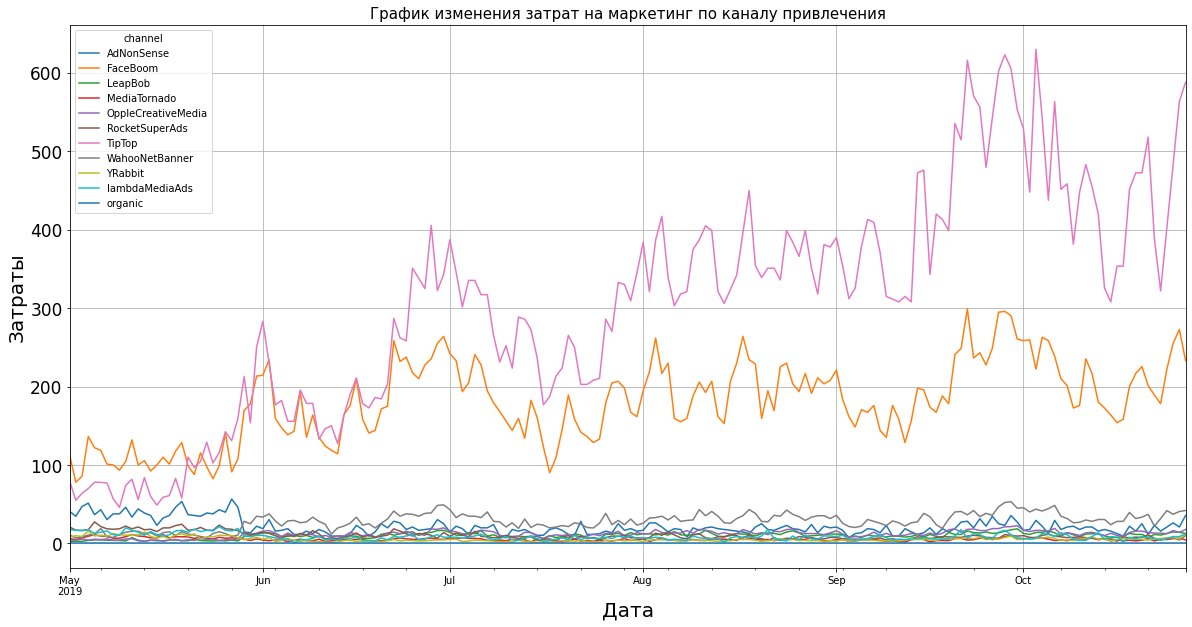

In [42]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  
    columns='channel', 
    values='acquisition_cost',  
    aggfunc='sum'  
).plot(figsize=(20, 10), grid=True)
plt.title('График изменения затрат на маркетинг по каналу привлечения')
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Затраты', fontsize=20)
plt.show()

Каналы привлечения, где затраты на маркетинг не превышали 100$ в день, слились в одну линию. Построим еще один график, в котором оставим только эти каналы.

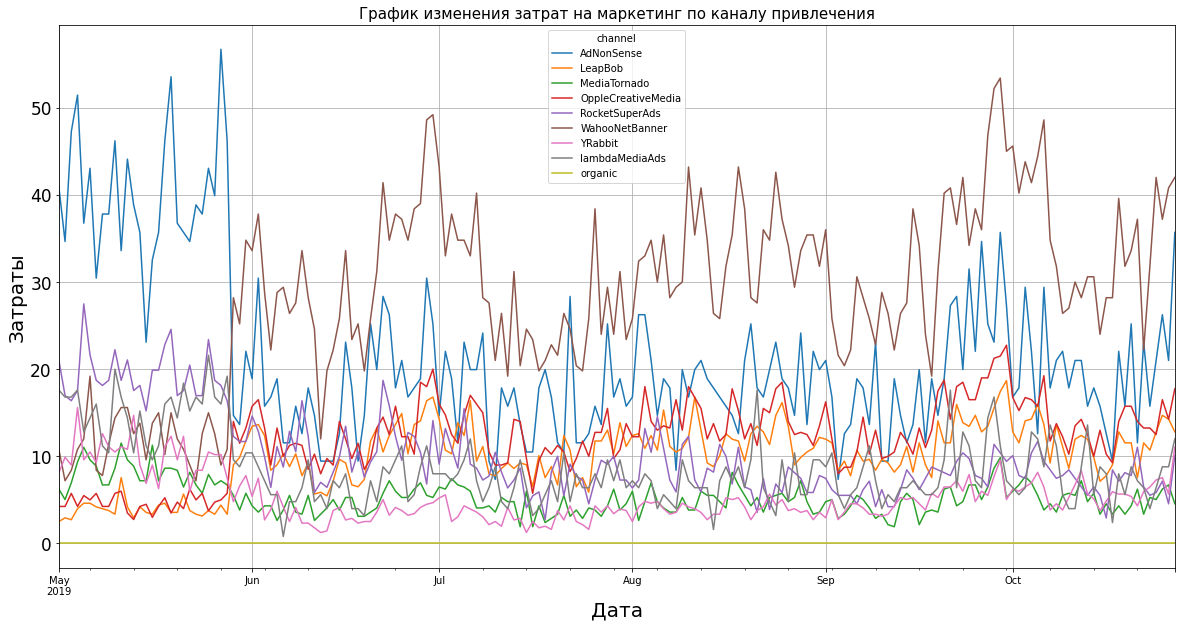

In [43]:
profiles.query('channel != ["TipTop", "FaceBoom"]').pivot_table(
    index='dt',  
    columns='channel', 
    values='acquisition_cost',  
    aggfunc='sum'  
).plot(figsize=(20, 10), grid=True)
plt.title('График изменения затрат на маркетинг по каналу привлечения')
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Затраты', fontsize=20)
plt.show()

**Вывод:** На графике видно, что изначально затраты на маркетинг по каждому каналу не превышали 100у.е. Затем происходит резкий рост затрат на рекламу в каналах Типтоп и Фэйсбум. Если на канал Фэйсбум затраты не превышали 300$ ежедневно на протяжении всего периода анализа, то на рекламу в канале Типтоп затраты росли на протяжении всего периода, и порой превышали 600у.е. Чем это вызвано, по-прежнему сложно сказать. Надеюсь, мы найдем ответ на этот вопрос при дальней шем анализе.

**Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника**

In [44]:
cost_mean = profiles.groupby('channel').agg({'acquisition_cost': 'mean'})\
.sort_values(by='acquisition_cost', ascending=False).reset_index()
cost_mean

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


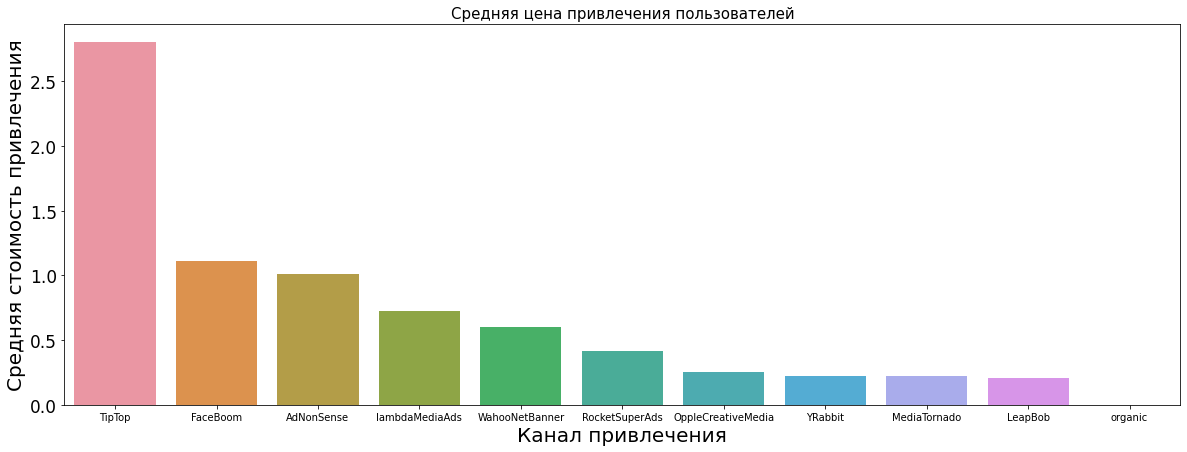

In [45]:
plt.figure(figsize=(20,7))
plt.title('Средняя цена привлечения пользователей')
sns.barplot(data=cost_mean, x='channel', y='acquisition_cost')
plt.xlabel('Канал привлечения', fontsize=20)
plt.ylabel('Средняя стоимость привлечения', fontsize=20);

**Вывод:** Видим что дороже всего обходится привлечение пользователей из канала Типтоп, и это неудивительно, ведь около половины бюджета на рекламу приходится на этот канал. Пользователи из канала Фэйсбум и AdNoneSense обходятся в среднем в 1$.  
Предварительно, могу сказать, что траты на маркетинг в канале Типтоп, необосновано высоки.

### Оценим окупаемость рекламы


**Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.**

Для начала, зададим горизонт данных и момент анализа. Избавимся от "оргинических" пользователей, так как они могут исказить наши показатели при дальнейшем анализе.

In [46]:
profiles = profiles.query('channel != "organic"') #исключаем из таблицы органических пользователей.
observation_date = datetime(2019, 11, 1).date()  # задаём момент анализа 
horizon_days = 14  #задаём горизонт анализа 

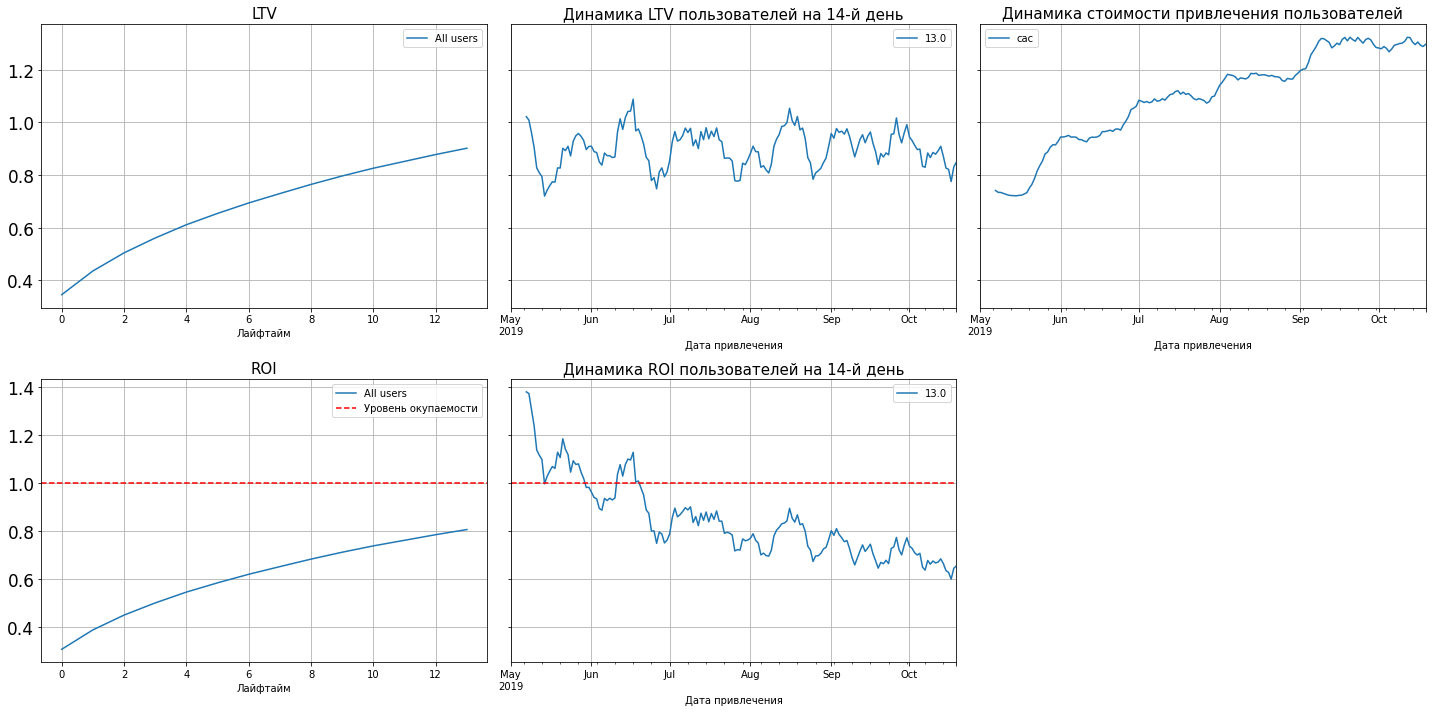

In [47]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:** Из плюсов: LTV стабильно идёт вверх, значит прибыль с каждого клиента возрастает на протяжении всего "лайфтайма". На остальных графиках мы видим печальную картину: окупаемость пользователей к концу второй недели составляет всего лишь 80%. Показатель САС на протяжении всего периода стабильно растёт, в то время как показатель ROI стабильно идёт вниз. С июня месяца привлеченные пользователи не окупаются.

**Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.**

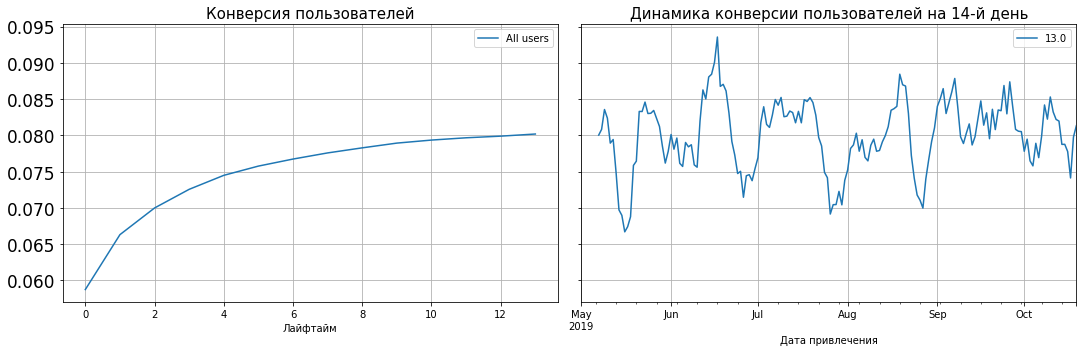

In [48]:
#смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Исходя из графиков, пользователи конвертируются неплохо первые 4 дня "жизни", далее конверсия тоже растёт, но уже не такими большими темпами.

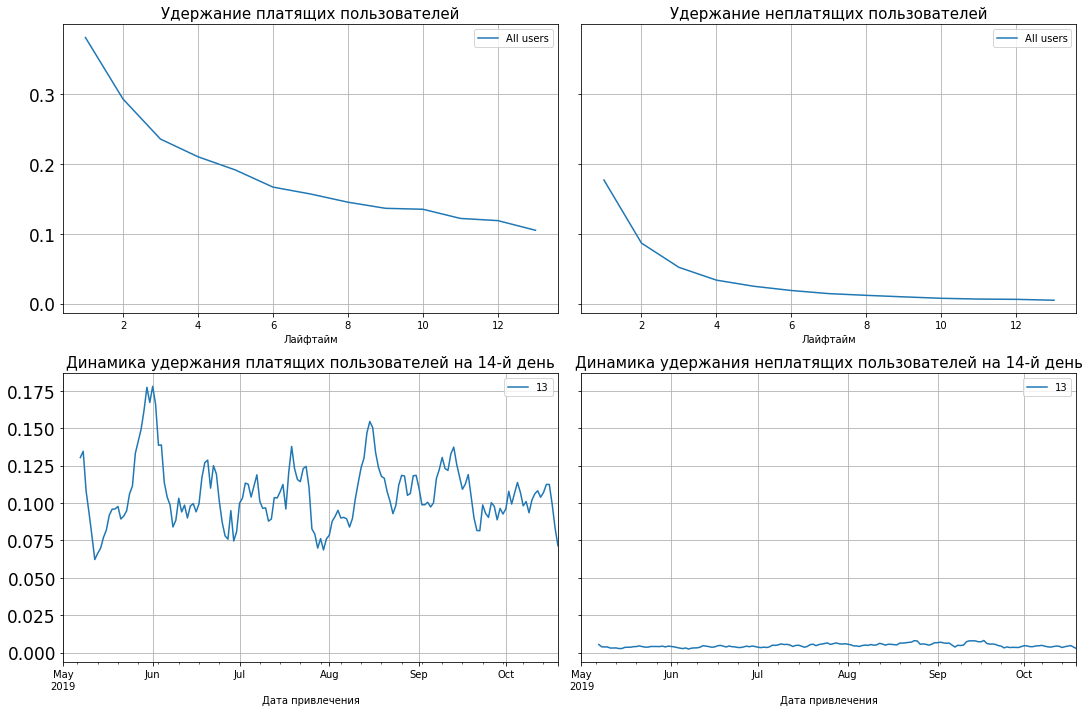

In [49]:
#смотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:** Удержание платящих пользователей на первый день "жизни" составляет менее 40%. К концу второй недели остается всего 10%.  По динамике удержания мы видим, что через две недели после привлечения остается в среднем от 7 до 12% пользователей. Максимально удержание на 14ы день наблюдалось июне- 17%. Неплатящие пользователи вообще не задерживаются тут надолго.

**Проанализируем окупаемость рекламы с разбивкой по устройствам.**

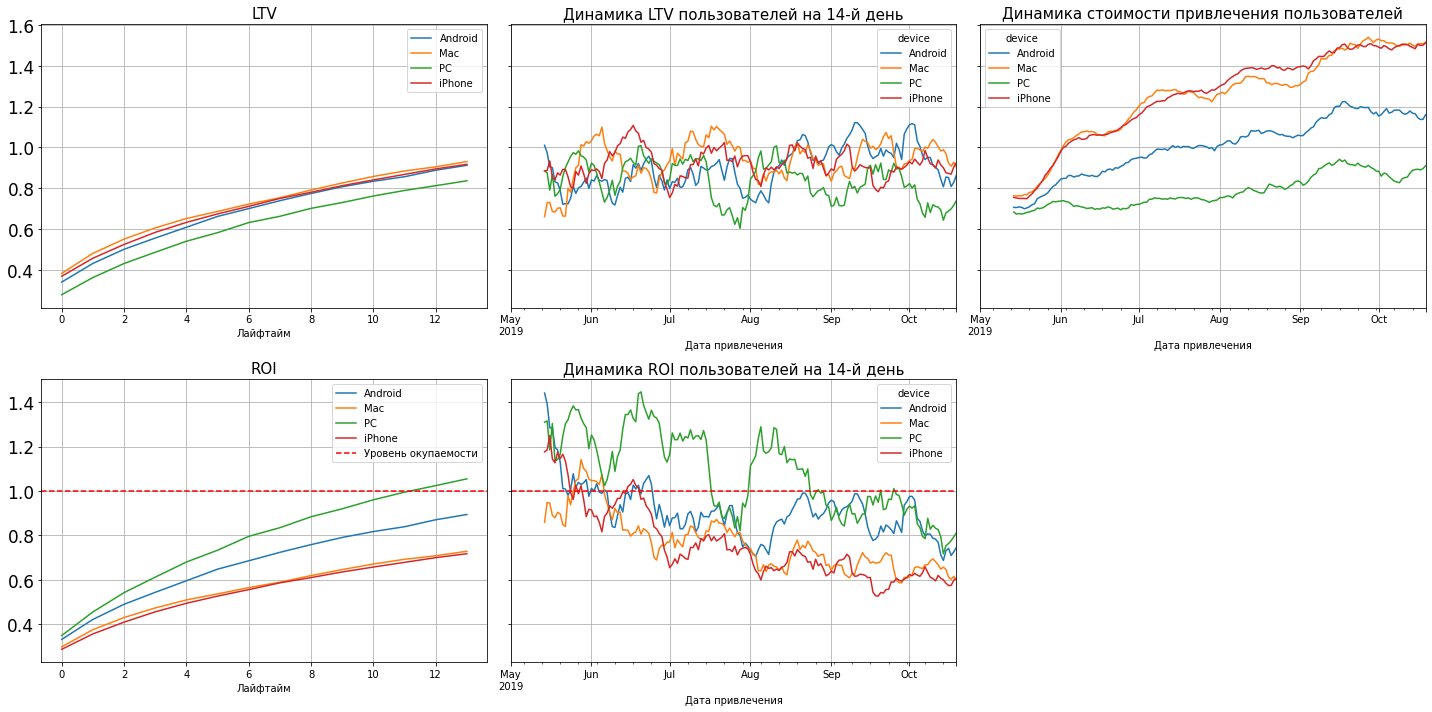

In [50]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:** LTV пользователей всех устроиств стабильно растёт.LTV держателей ПК ниже, чем пользователей с других устройств, но, если смотреть на окупаемость, то как раз-таки окупается только эта категория пользователей. Со временем затраты на привлечение держателей Айфона и МАКа значительно выше, чем привлечение пользователей с Андроида и ПК.  
Динамика ROI говорит нам о том, что мае-июне месяце окупались практически все пользователи, а далее с большей или меньшей степенью ROI стал падать. Стремительнее всего падала окупаемость пользователей с Айфон. А вот пользователи с ПК окупались самое большее время. В сентябре- октябре окупаемасть ушла в минус для пользователей всех устройств.

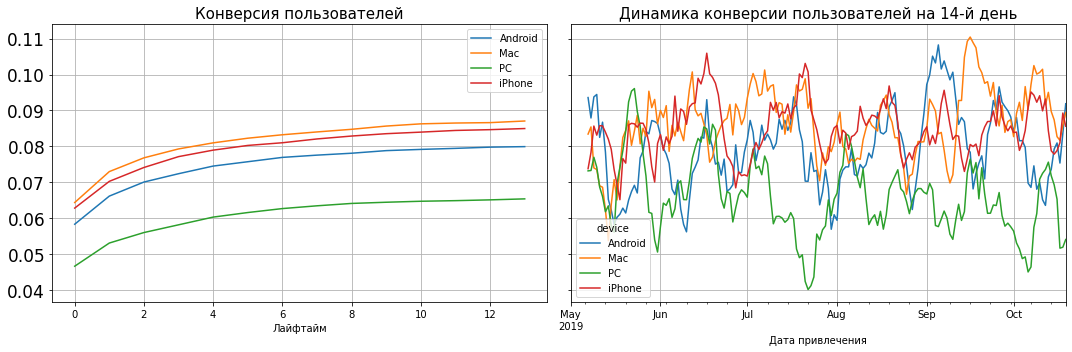

In [51]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи МАСов, Айфонов и Андроидов конвертируютя лучше пользователй ПК, причем на протяжении всего времени.

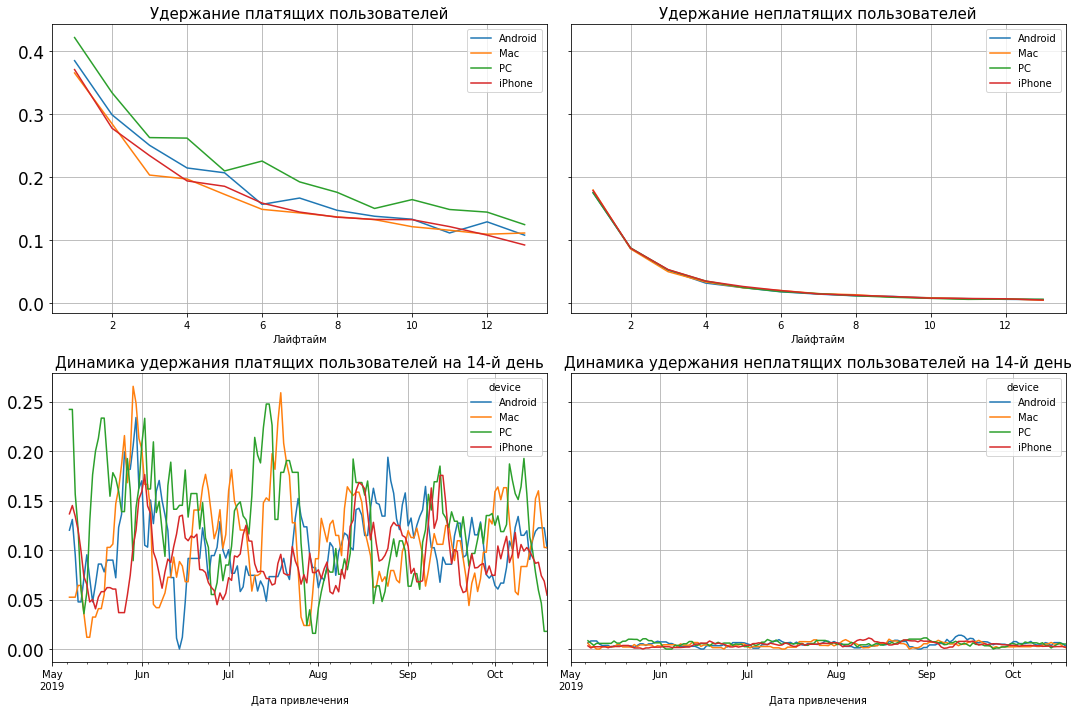

In [52]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

График удержания платящих пользователей плавный, резких скачков не наблюдается. 

**Проанализируем окупаемость рекламы с разбивкой по странам.**

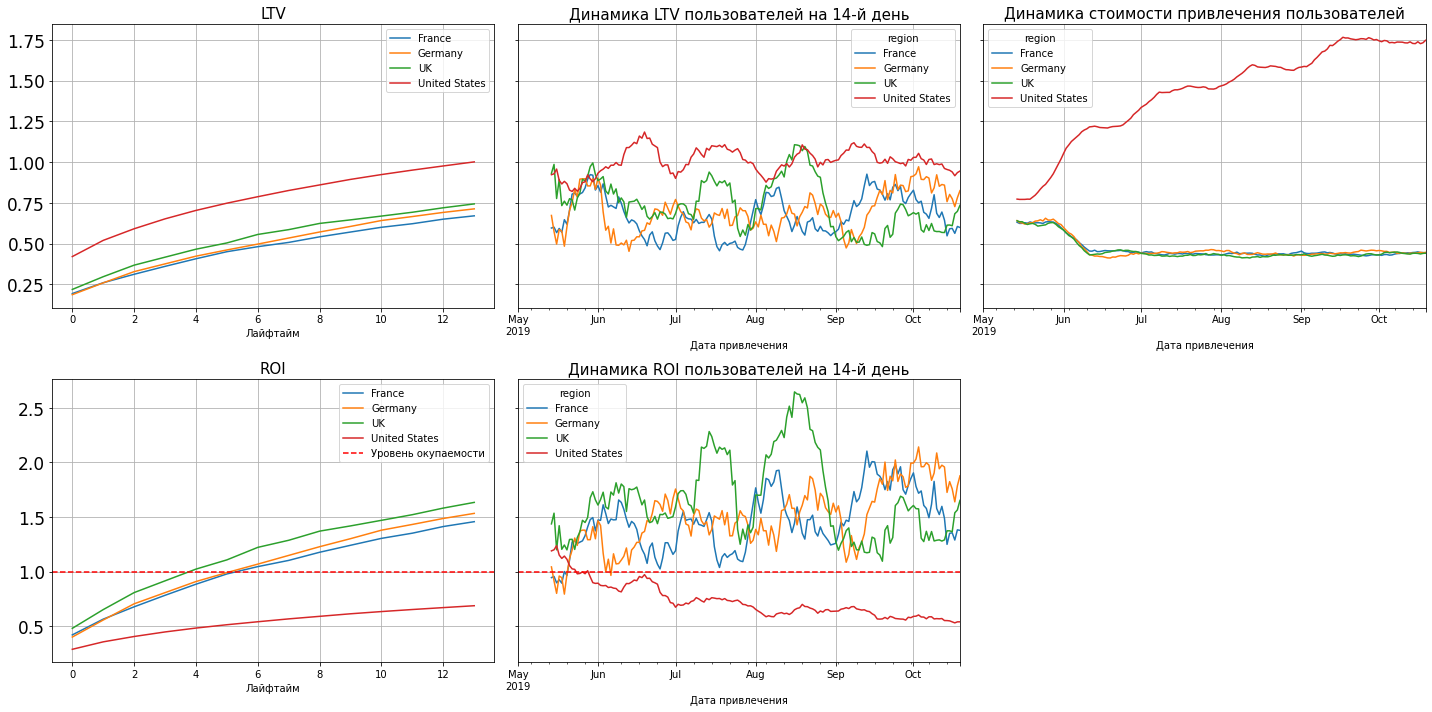

In [53]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:** Судя по всему, ответ на наш вопрос: в чем причина убыточности приложения, кроется в этих графиках. Здесь отчетливо видно нехарактерное поведение красной линии, а именно пользователей из США. Несмотря на то, что пользователи США имеют бОльшую "пожизненную ценность", т.е. сумарно приносят больше прибыли, ROI пользователей этой страны ниже, чем у пользователей других стран. И на протяжении, практически, всего времени, "США" не окупаются. А всё потому, что САС у них стремительно растёт. Здесь так же можно заметить, что ROI пошёл в минус именно тогда, когда начали резко возрастать затраты на рекламу.  
Посмотрим на удержание пользователей из США

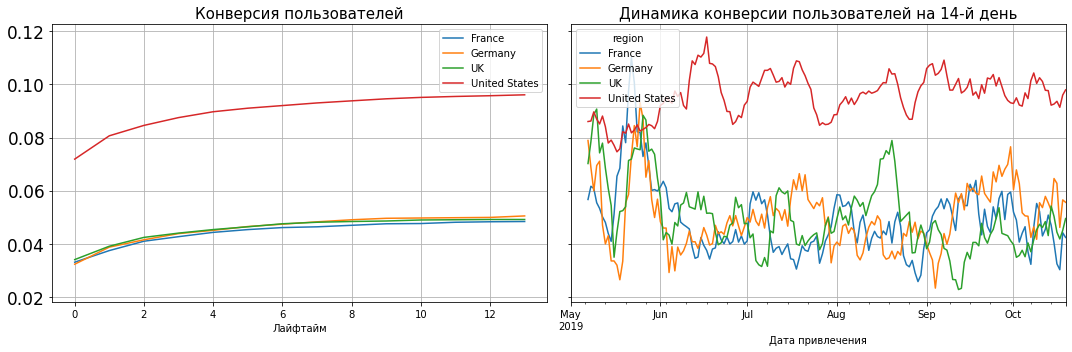

In [54]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия позователей из Франции, Германии, Великобритании уступает пользователям из США. Но, если смотреть динамику, то мы видим что в конце мая конверсия этих трех стран превышала конверсию пользователей из США, а дальше конвертация вновь пошла на убыль, и взлетов больше не наблюдалось.

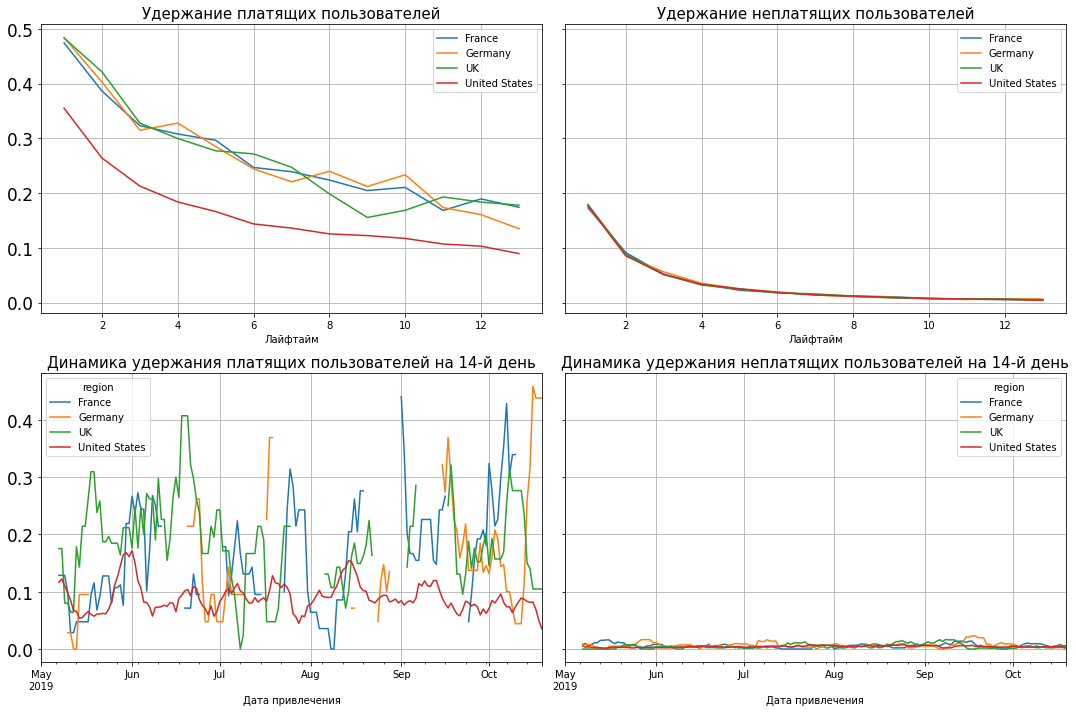

In [55]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

Так же пользователи из США удерживаются хуже остальных, поэтому огромные траты на рекламу там не окупаются.

**Проанализируем окупаемость рекламы с разбивкой по рекламным каналам**

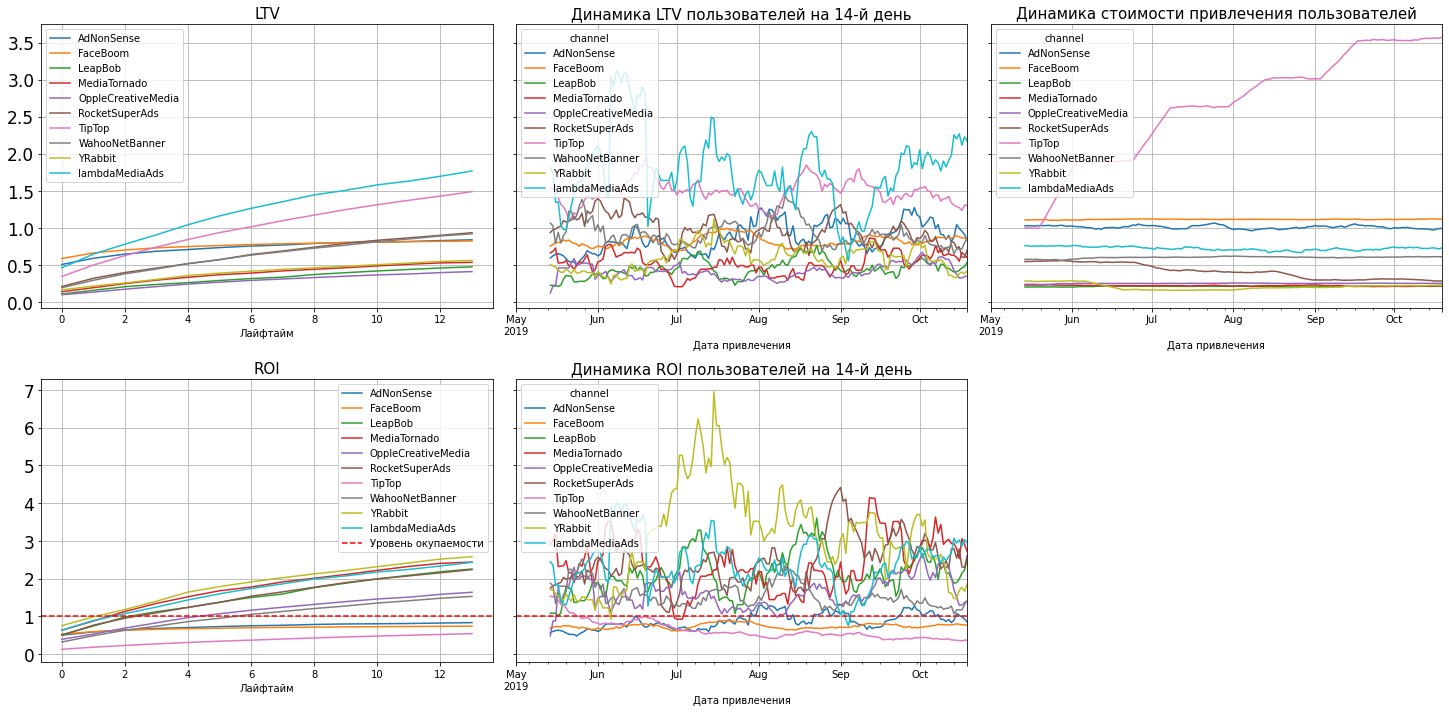

In [56]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:** LTV у всех пользователей имеет положительную динамику, несмотря на канал привлечения. Найбольшую ценность представляют пользователи, привлеченные с Лямбда и Типтоп. Опять же САС зашкаливает у пользователей с Типтоп, и как следствие, на графике ROI, мы видим отсутствие окупаемости у данной категории пользователей. А вот окупаемость пользователей, привлечённых с других каналов, во многом показывает высокую рентабельность, стоит обратить на них внимание! В первую очередь, это:  YRabbit, Лямбда, Медиаторнадо.  
Типтоп, AdNoneSense и Фэйсбум тут, безусловно, в аутсайдерах: судя по графику динамики ROI, они не выходили в плюс за весь анализируемый период.

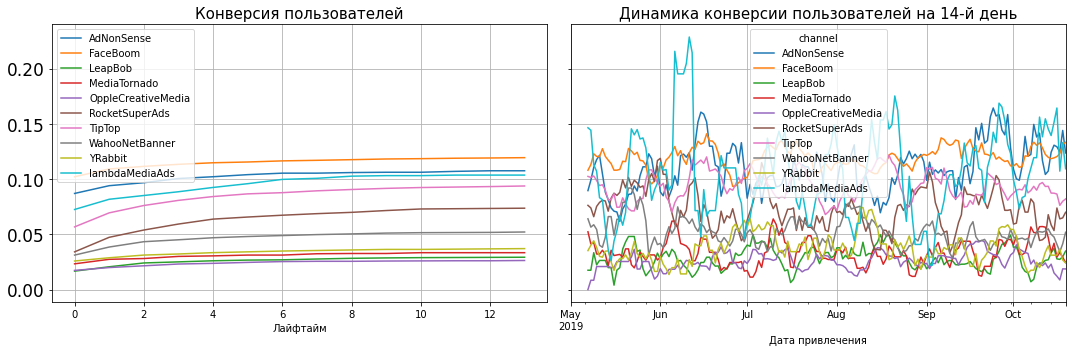

In [57]:
#смотрим конверсию по каналам привлечения
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Плохо конвертируются пользователи из каналов OppleCreativeMedia, MediaTornado, YRabbit, LeapBob. Динамика конверсии пользователей из Лямбдамедиа очень нестабильна: на графике видны резкие взлеты и падения в разные периоды.

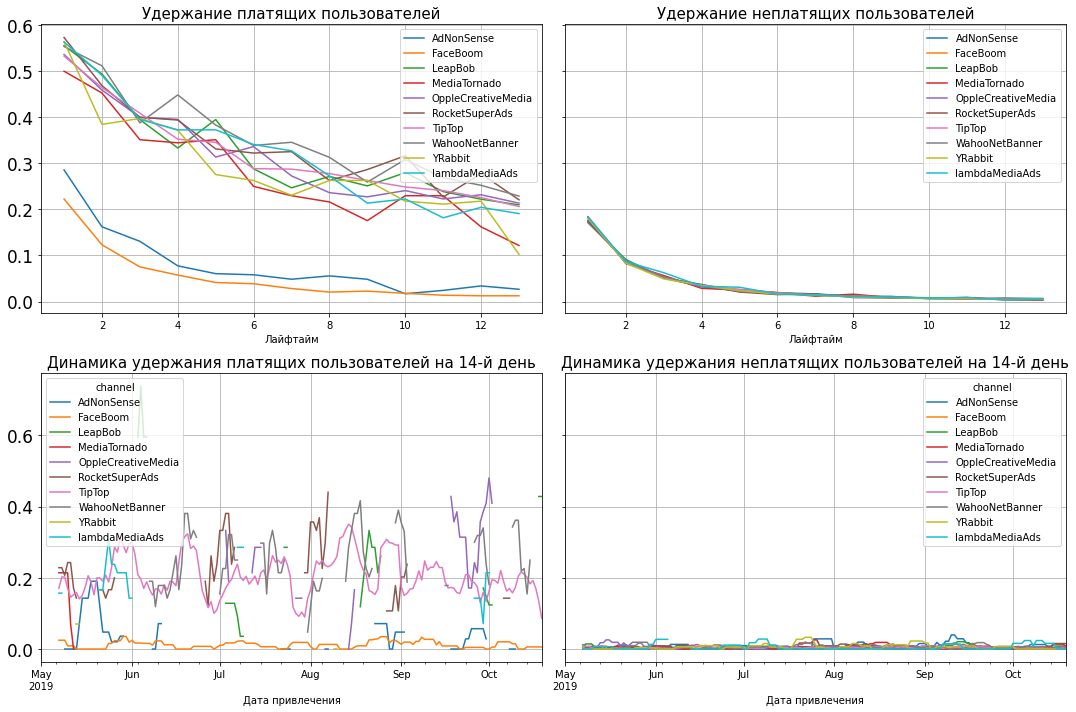

In [58]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

В дополнение ко всему вышесказанному, можно добавить, что пользователи с каналов AdNoneSense и Фэйсбум также удерживаются хуже всего, поэтому бюджет на рекламу в этих каналах стоит сократить в разы. 

### Общий вывод

Причины неэффективности привлечения пользователей следующие:

- Пользователи США перестали окупаться в тот момент, когда САС резко подскочил вверх. Эффекта реклама не произвела, а вот ROI из-за этого резко пошел вниз.
- Мало внимания уделяется владельцам ПК - они удерживаются лучше других, и единственные из всех устройств окупаются к концу второй недели. 
- Удержание платящих пользователей из США оказалось хуже остальных.
- Пользователи,пришедшие из каналов Типтоп и Фэйсбум не окупились по причине больших затрат на рекламу
- Пользователи из канала Фесбум и AdNoneSense удерживаются хуже других


Рекомендации для отдела маркетинга:

- Владельцы ПК удерживаются лучше всего, и единственные из всех устройств окупаются к концу второй недели -стоит обратить на них внимание
- Так же стоит обратить внимание на привлечение пользователей, использующих Андроид.
- Уменьшить затраты на маркетинг в США
- Привлекать больше пользователей с каналов Лямбда. 
- Уменьшить траты на рекламу в канале Фейсбум и AdNoneSense